In [56]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from models import Asso, AssoTrans, AssoOpt, AssoExIterate
import pandas as pd
from utils import show_matrix, matmul
import pickle
import glob
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load MovieLens data

[<943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

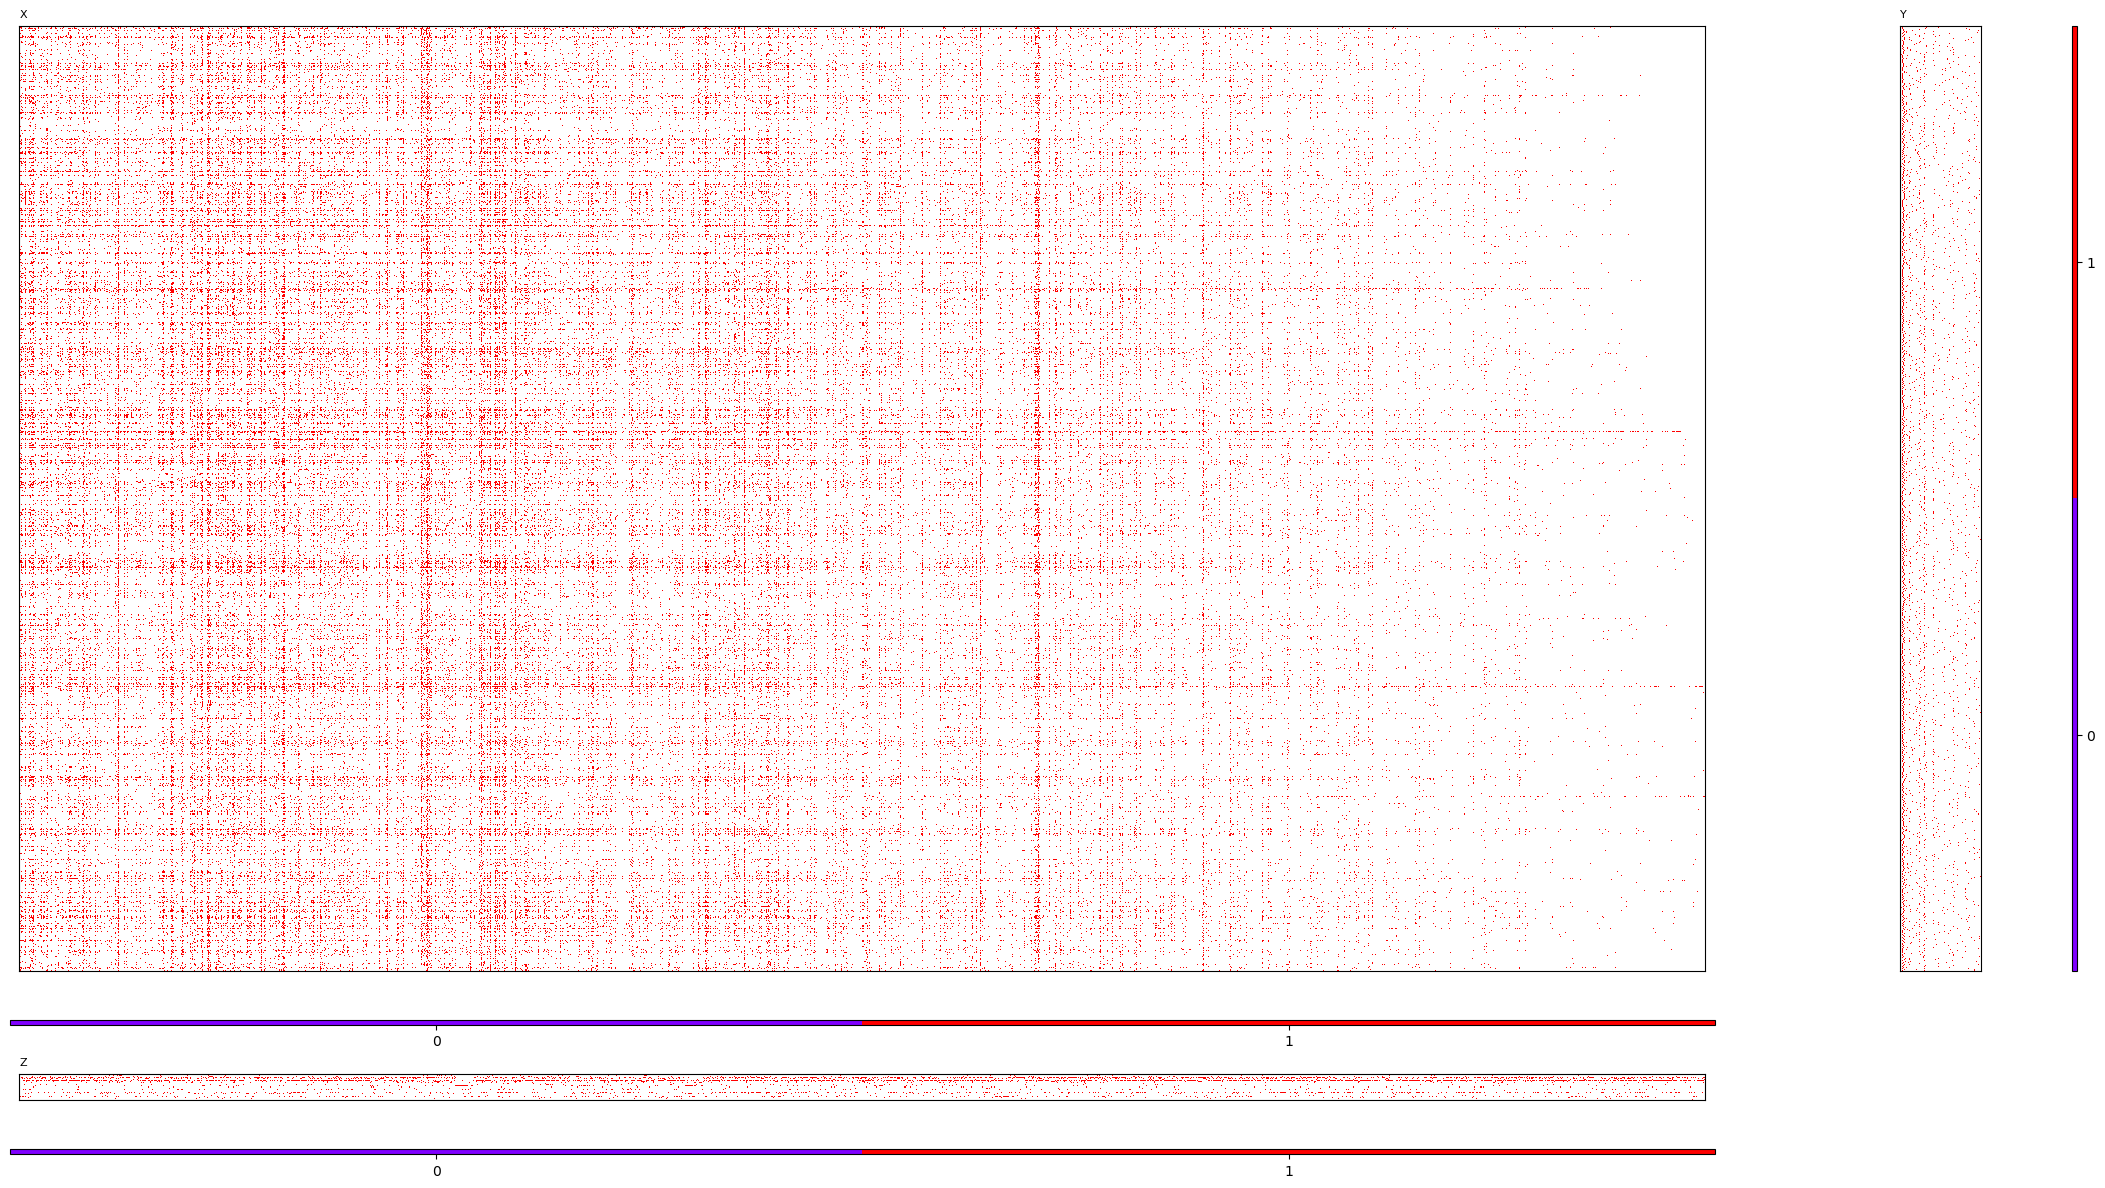

In [57]:
from datasets import MovieLensData, MovieLensGenreCastUserData

data = MovieLensGenreCastUserData(size='100k')

data.load()
display(data.Xs)

X, Y, Z, _ = data.Xs
show_matrix([(X, [0, 0], 'X'), 
             (Y, [0, 1], 'Y'), 
             (Z, [1, 0], 'Z')], 
             colorbar=True, keep_nan=True, discrete=True, center=True, clim=[0, 1])

In [58]:
from datasets import NoSplit, RatioSplit

split = RatioSplit(X=X, val_size=0.1, test_size=0.2, seed=1000)
split.negative_sample(train_size=split.pos_train_size, 
                      val_size=split.pos_val_size, 
                      test_size=split.pos_test_size, type='popularity')

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

[I] RatioSplit, sampling positives
[I]   seed         : 1000
[I]   train_size   : 70000
[I]   val_size     : 10000
[I]   test_size    : 20000
[I]   seed         : 1000
[I] RatioSplit, sampling negatives
[I]   all_negatives: 1486126
[I]   n_negatives  : 100000
[I]   train_size   : 70000
[I]   val_size     : 10000
[I]   test_size    : 20000
[I]   seed         : 1000


c:\Users\nieht\Anaconda3\envs\cornac\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


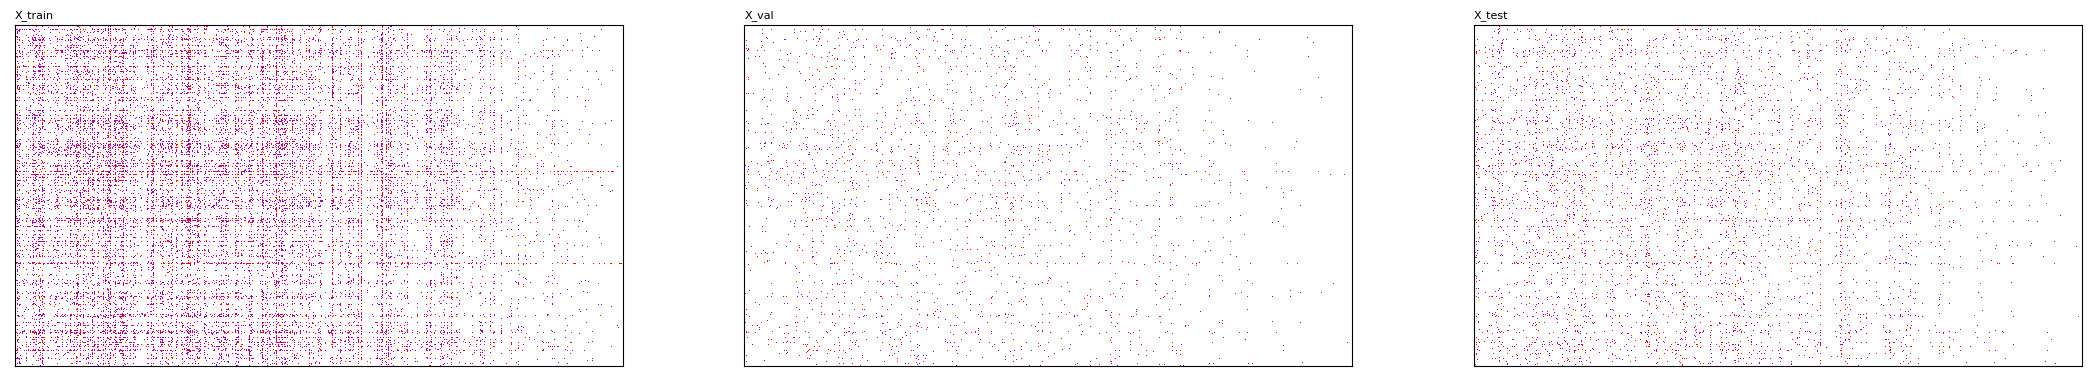

In [59]:
show_matrix([(X_train, [0, 0], 'X_train'), 
             (X_val, [0, 1], 'X_val'), 
             (X_test, [0, 2], 'X_test')], 
             keep_nan=True, clim=[0, 1], discrete=True, center=True)

### Load candidates

In [130]:
pickles = glob.glob("./*.pkl")
pickles

['.\\02_51_33_candidates_0.pkl',
 '.\\03_01_54_candidates_1.pkl',
 '.\\03_20_13_candidates_2.pkl',
 '.\\03_22_25_candidates_3.pkl',
 '.\\03_24_29_candidates_4.pkl',
 '.\\03_29_44_candidates_0.pkl',
 '.\\03_39_17_candidates_1.pkl',
 '.\\03_45_14_candidates_2.pkl',
 '.\\03_48_51_candidates_3.pkl',
 '.\\03_54_57_candidates_4.pkl',
 '.\\04_00_02_candidates_0.pkl',
 '.\\04_10_30_candidates_1.pkl',
 '.\\04_15_00_candidates_2.pkl',
 '.\\04_20_10_candidates_3.pkl',
 '.\\04_26_16_candidates_4.pkl',
 '.\\10_58_51_tau0.25_candidates_0.pkl',
 '.\\11_07_09_tau0.25_candidates_1.pkl',
 '.\\11_10_41_tau0.25_candidates_2.pkl',
 '.\\11_12_56_tau0.25_candidates_3.pkl',
 '.\\11_15_37_tau0.25_candidates_4.pkl',
 '.\\11_26_29_tau0.25_scores_5.pkl',
 '.\\11_37_51_tau0.55_candidates_0.pkl',
 '.\\11_46_45_tau0.55_candidates_1.pkl',
 '.\\11_51_12_tau0.55_candidates_2.pkl',
 '.\\11_54_28_tau0.55_candidates_3.pkl',
 '.\\12_00_19_tau0.55_candidates_4.pkl',
 '.\\12_00_20_tau0.55_scores_5.pkl',
 '.\\12_23_15_tau0.15

In [131]:
pickles = glob.glob("./*.pkl")
pickles = [
 '.\\12_23_15_tau0.15_candidates_0.pkl',
 '.\\12_31_30_tau0.15_candidates_1.pkl',
 '.\\12_35_01_tau0.15_candidates_2.pkl',
 '.\\12_37_15_tau0.15_candidates_3.pkl',
 '.\\12_38_51_tau0.15_candidates_4.pkl',
]
pickles

['.\\12_23_15_tau0.15_candidates_0.pkl',
 '.\\12_31_30_tau0.15_candidates_1.pkl',
 '.\\12_35_01_tau0.15_candidates_2.pkl',
 '.\\12_37_15_tau0.15_candidates_3.pkl',
 '.\\12_38_51_tau0.15_candidates_4.pkl']

### Load scores

[26] [6934.5]


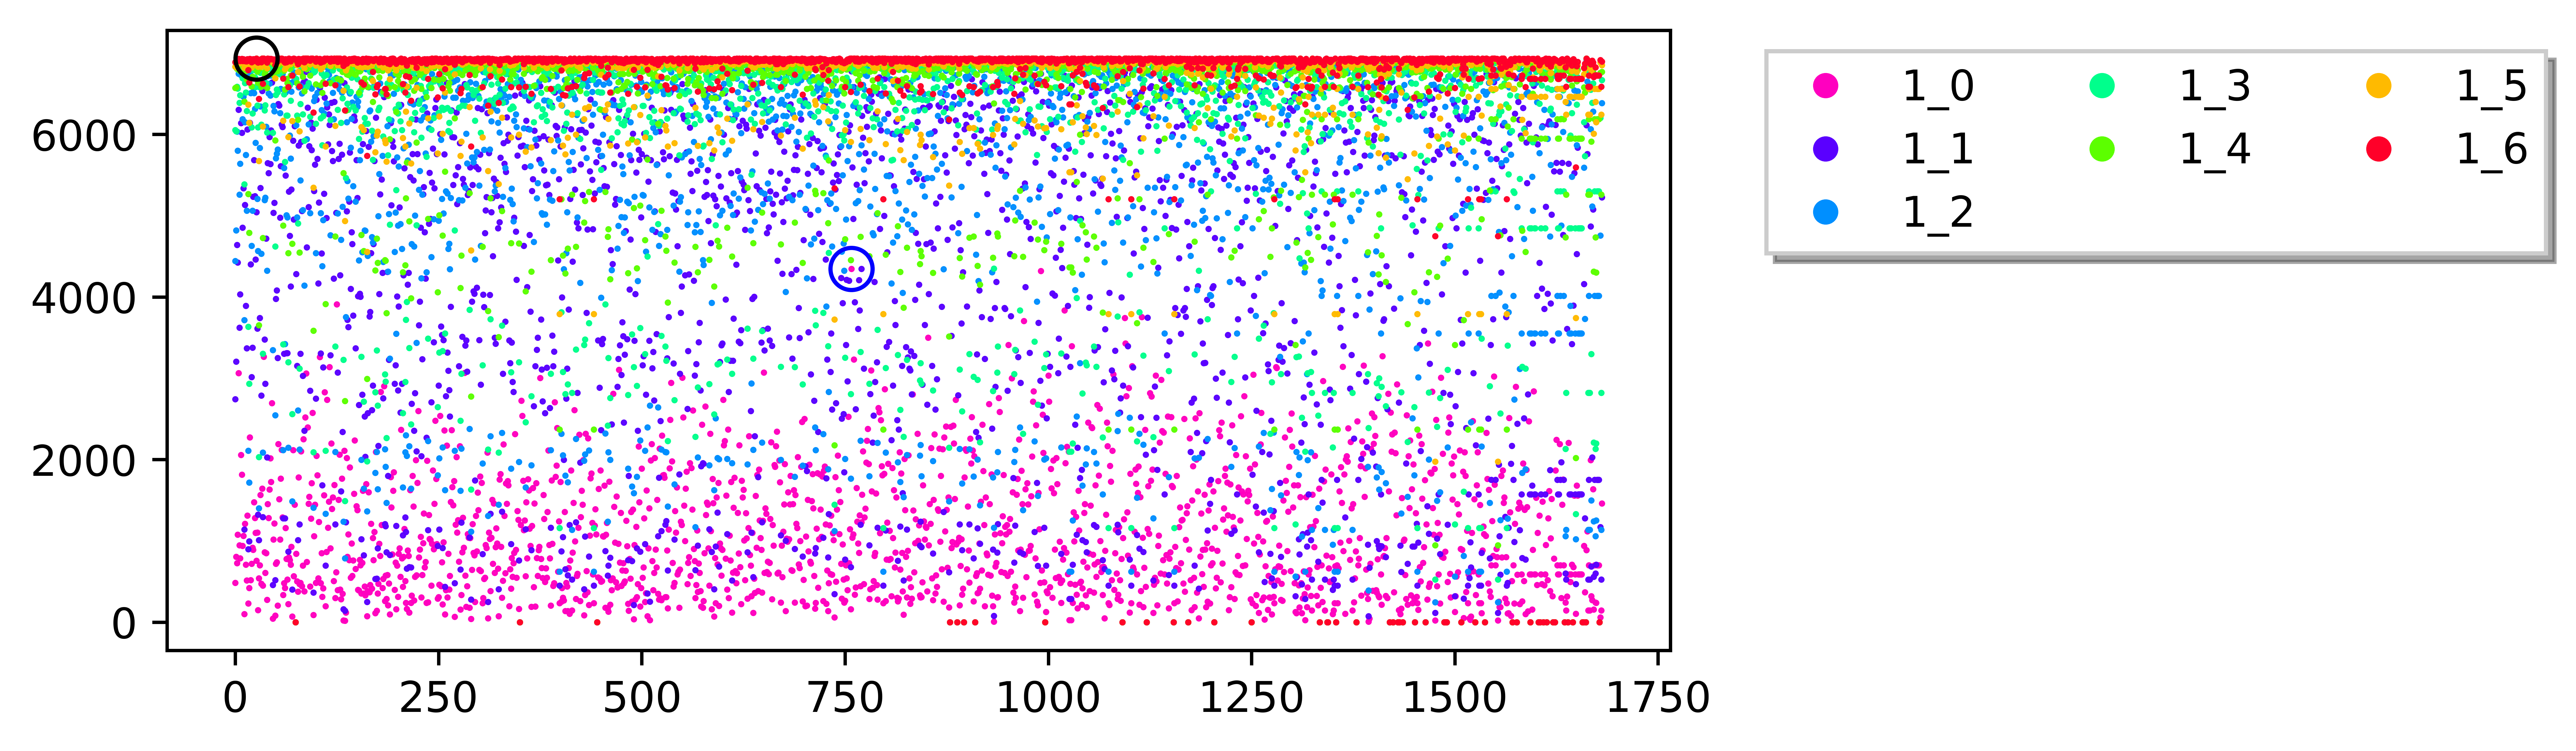

In [139]:
import matplotlib.pyplot as plt
K = 5

with open("12_00_20_tau0.55_scores_5.pkl", 'rb') as f:
    scores_pickle = pickle.load(f)

n_candidates = len(scores_pickle[0])
best_ids = []
best_scores = []

color_list = []

plt.figure(0, dpi=1000)
# plt.gca().set_prop_cycle(color=[
#     '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
#     '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
#     '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
#     '#17becf', '#9edae5'])

for k in range(K):
    n_updates = len(scores_pickle[k][0])
    scores = np.zeros((n_candidates, n_updates))

    bias = 0
    for c in range(n_candidates):
        if c in best_ids:
            idx = best_ids.index(c)
            scores[c, :] = best_scores[idx]
            bias += 1
        else:
            if c-bias >= len(scores_pickle[k]):
                print(k, c, bias)
            scores[c, :] = scores_pickle[k][c-bias]

    best_id = np.argmax(scores[:, -1])
    best_ids.append(best_id)
    best_scores.append(scores[best_id, -1])
    print(best_ids, best_scores)

    colors = plt.cm.gist_rainbow(np.flip(np.linspace(0, 1, n_updates)))
    plt.gca().set_prop_cycle(color=colors)
    p = plt.plot(scores, '.', markersize=1, label=[f"{k+1}_{i}" for i in range(n_updates)])
    
    # p = plt.plot(scores[:, 0], '.', markersize=1, label='1_0')
    # plt.plot(np.argmax(scores[:, 0]), np.max(scores[:, 0]), 'bo', markersize=10, fillstyle='none')
    # break
    
    # plt.plot(scores[:, -1], '.', markersize=1, label=f"{k+1}_{n_updates-1}")
    plt.plot(np.argmax(scores[:, 0]), np.max(scores[:, 0]), 'bo', markersize=10, fillstyle='none')

    break

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=3, fancybox=False, shadow=True, markerscale=10)

plt.gca().set_aspect(0.1)
# plt.gca().set_prop_cycle(color=color_list[:])

plt.plot(best_ids, best_scores, 'ko', markersize=10, fillstyle='none')
# plt.vlines(x = best_ids, ymin = 0, ymax = np.array(best_scores), colors = 'k')




In [112]:
with open("12_00_20_tau0.55_scores_5.pkl", 'rb') as f:
    scores_pickle = pickle.load(f)
    
k = 0

n_updates = len(scores_pickle[k][0])
scores = np.zeros((n_candidates, n_updates))

bias = 0
for c in range(n_candidates):
    if c in best_ids:
        idx = best_ids.index(c)
        scores[c, :] = best_scores[idx]
        bias += 1
    else:
        if c-bias >= len(scores_pickle[k]):
            print(k, c, bias)
        scores[c, :] = scores_pickle[k][c-bias]



In [111]:
scores.shape

(1682, 7)

In [128]:
scores.max(axis=0)

array([4345.5, 6776.5, 6929. , 6933.5, 6934.5, 6934.5, 6934.5])

In [149]:
len_list = []
max_list = []
for i in np.arange(start=1, step=1, stop=20):
    idx = np.random.choice(n_candidates, i, replace=False)
    len_list.append(len(idx))
    max_list.append(scores[idx, -1].max())

max_list

[6744.5,
 6885.0,
 6890.25,
 6933.5,
 6933.75,
 6933.5,
 6934.0,
 6932.25,
 6931.5,
 6934.5,
 6930.5,
 6933.5,
 6918.0,
 6934.0,
 6933.5,
 6933.5,
 6934.5,
 6933.0,
 6934.0]

In [151]:
len_list = []
max_list = []
for i in np.arange(start=1, step=1, stop=20):
    idx = np.random.choice(n_candidates, i, replace=False)
    len_list.append(len(idx))
    max_list.append(scores[idx, 0].max())

max_list

[1204.25,
 2803.0,
 1164.25,
 1565.0,
 1760.0,
 2236.0,
 2634.0,
 1624.0,
 2652.75,
 1985.0,
 2944.0,
 2897.0,
 1380.5,
 2827.25,
 1925.0,
 3097.5,
 2713.0,
 3703.0,
 2518.5]

In [147]:
max_list

[6904.0,
 6933.5,
 6933.0,
 6934.5,
 6933.75,
 6930.5,
 6934.5,
 6933.5,
 6933.5,
 6927.5,
 6934.0,
 6934.5,
 6933.5,
 6934.5,
 6933.75,
 6934.0,
 6932.25,
 6933.75,
 6933.5]

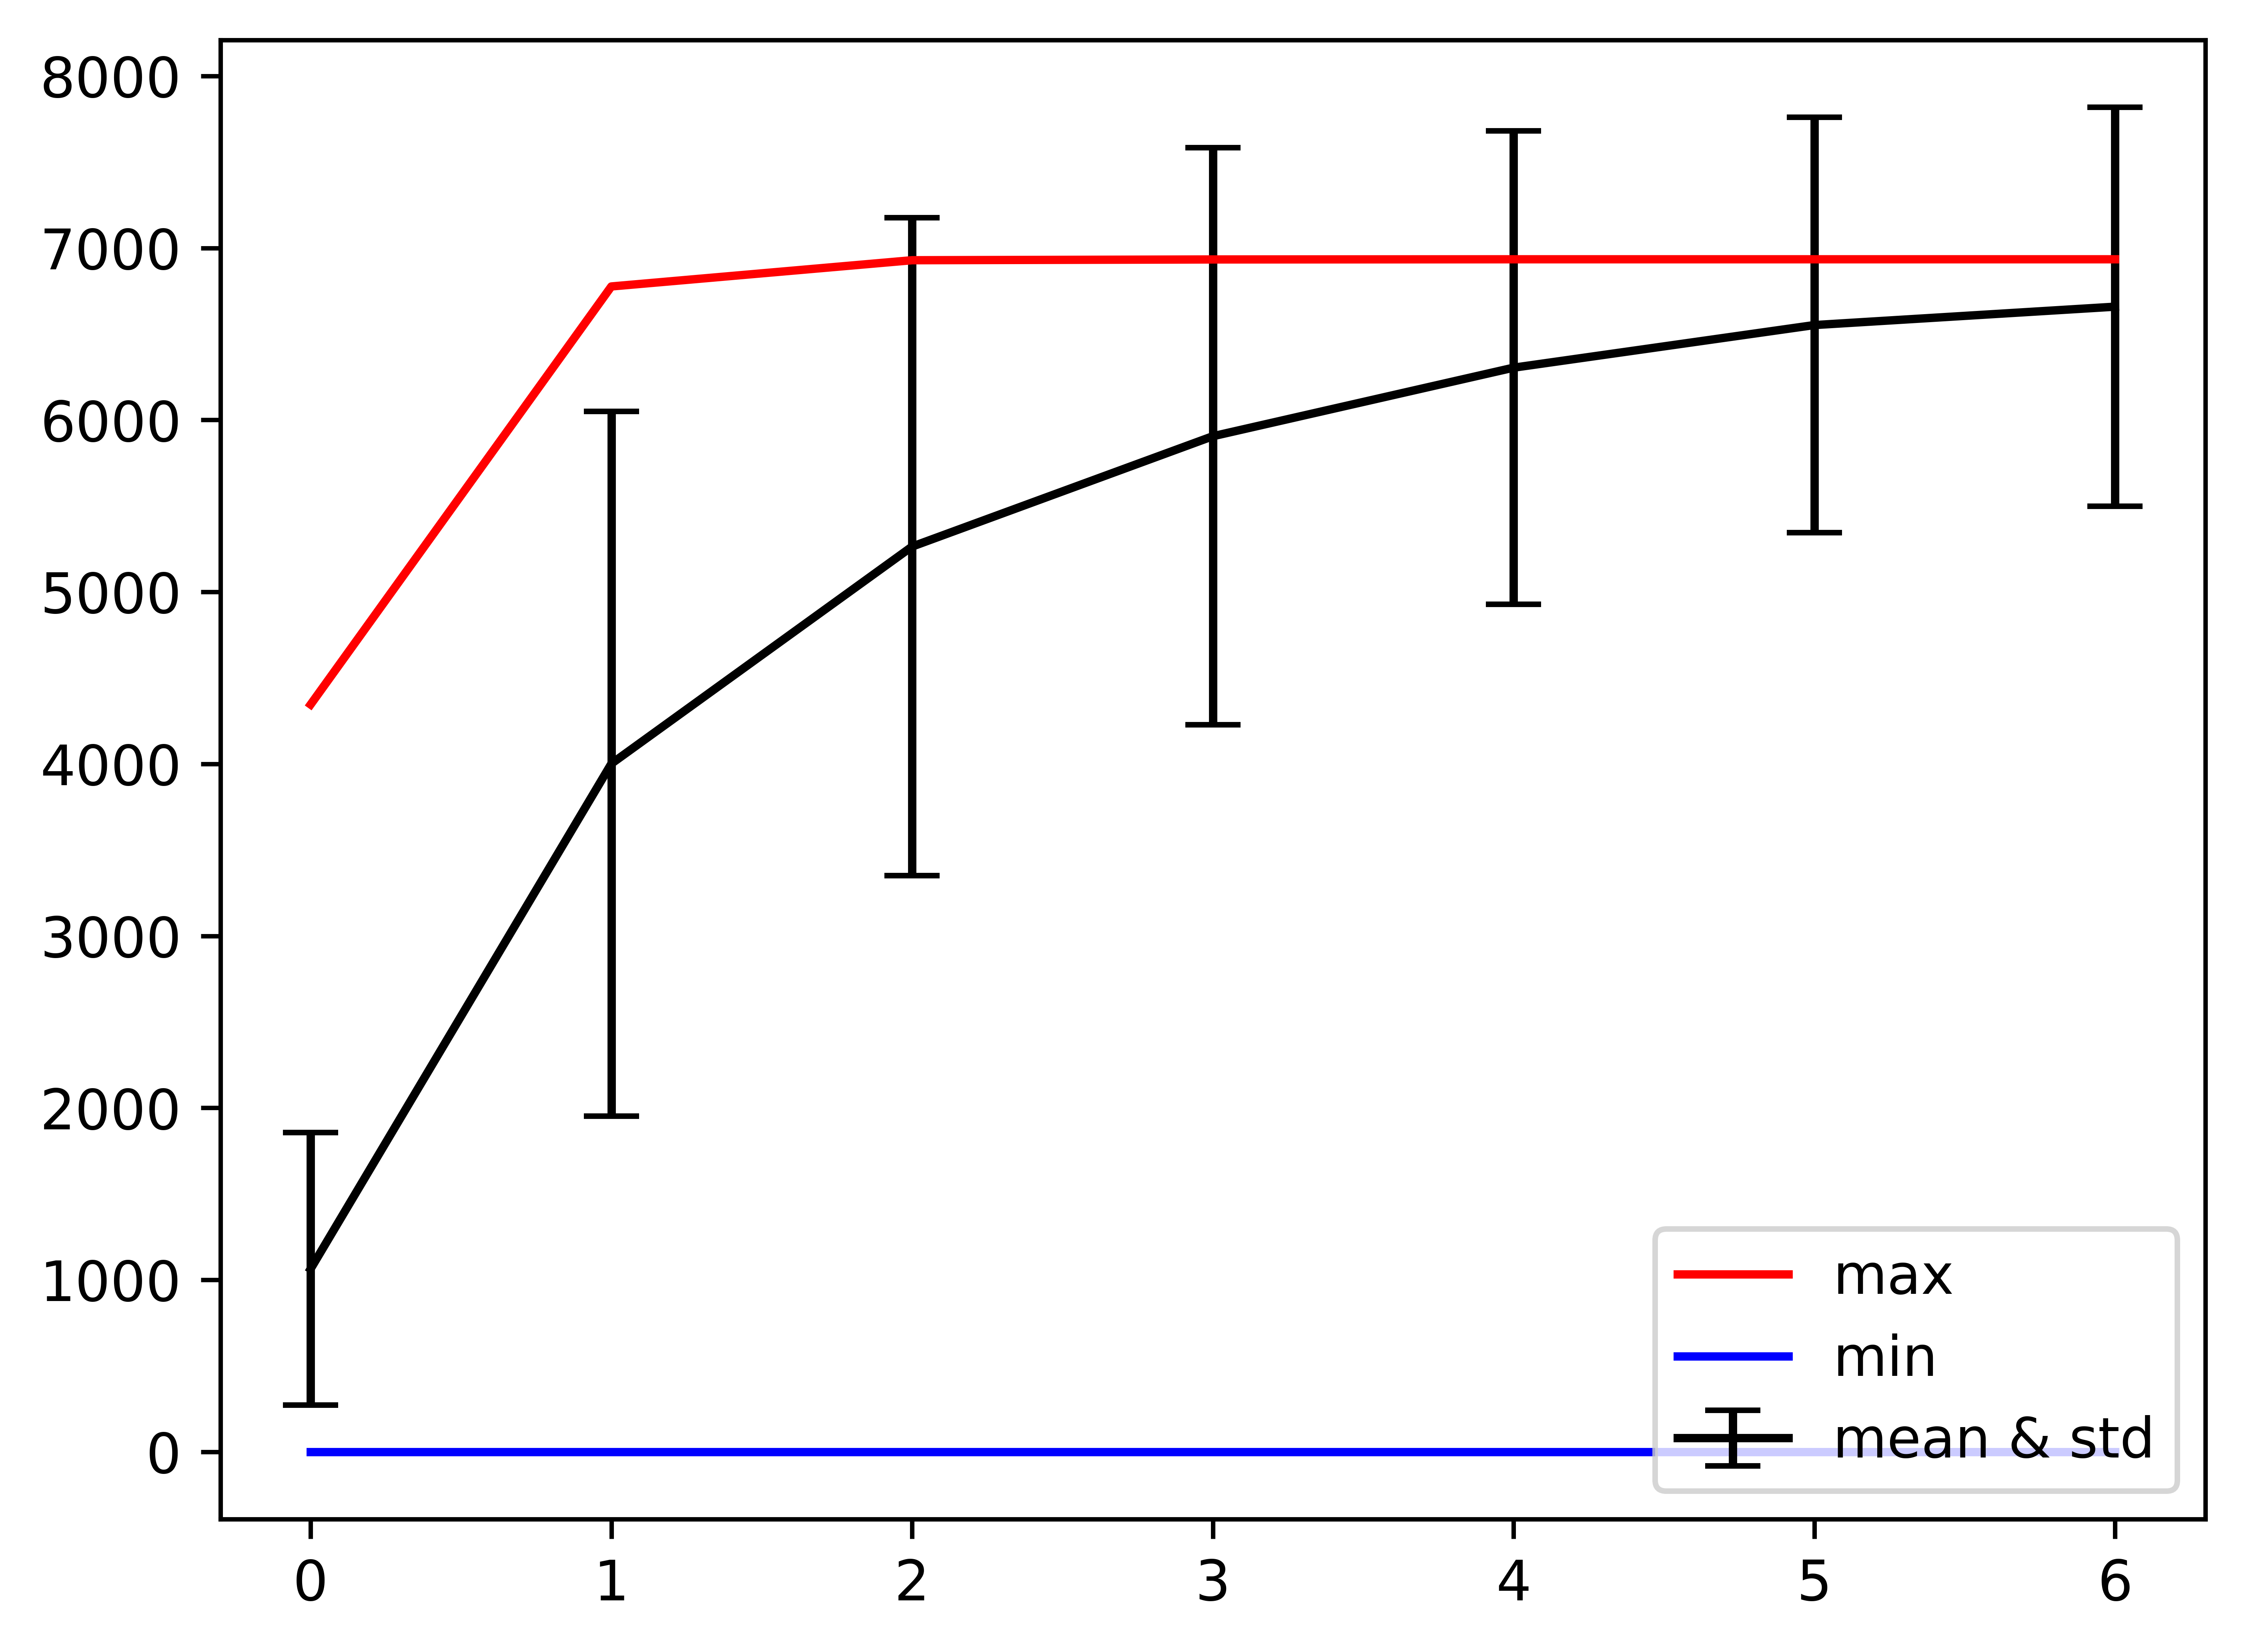

In [129]:
plt.figure(1, dpi=1000)
plt.errorbar(x=np.arange(n_updates), y=scores.mean(axis=0), yerr=scores.std(axis=0), 
             color='black', capsize=5, label='mean & std')
plt.plot(np.arange(n_updates), scores.max(axis=0), color='red', label='max')
plt.plot(np.arange(n_updates), scores.min(axis=0), color='blue', label='min')

plt.legend(loc='lower right')

In [ ]:
import matplotlib.pyplot as plt
K = 5

with open("12_00_20_tau0.55_scores_5.pkl", 'rb') as f:
    scores_pickle = pickle.load(f)

n_candidates = len(scores_pickle[0])
best_ids = []
best_scores = []

color_list = []

plt.figure(0, dpi=1000)
# plt.gca().set_prop_cycle(color=[
#     '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
#     '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
#     '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
#     '#17becf', '#9edae5'])

for k in range(K):
    n_updates = len(scores_pickle[k][0])
    scores = np.zeros((n_candidates, n_updates))

    bias = 0
    for c in range(n_candidates):
        if c in best_ids:
            idx = best_ids.index(c)
            scores[c, :] = best_scores[idx]
            bias += 1
        else:
            if c-bias >= len(scores_pickle[k]):
                print(k, c, bias)
            scores[c, :] = scores_pickle[k][c-bias]

    best_id = np.argmax(scores[:, -1])
    best_ids.append(best_id)
    best_scores.append(scores[best_id, -1])
    print(best_ids, best_scores)

    colors = plt.cm.gist_rainbow(np.flip(np.linspace(0, 1, n_updates)))
    plt.gca().set_prop_cycle(color=colors)
    p = plt.plot(scores, '.', markersize=1, label=[f"{k+1}_{i}" for i in range(n_updates)])
    
    # p = plt.plot(scores[:, 0], '.', markersize=1, label='1_0')
    # plt.plot(np.argmax(scores[:, 0]), np.max(scores[:, 0]), 'bo', markersize=10, fillstyle='none')
    # break
    
    # plt.plot(scores[:, -1], '.', markersize=1, label=f"{k+1}_{n_updates-1}")
    plt.plot(np.argmax(scores[:, 0]), np.max(scores[:, 0]), 'bo', markersize=10, fillstyle='none')

    # break

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=3, fancybox=False, shadow=True, markerscale=10)

plt.gca().set_aspect(0.1)
# plt.gca().set_prop_cycle(color=color_list[:])

plt.plot(best_ids, best_scores, 'ko', markersize=10, fillstyle='none')
# plt.vlines(x = best_ids, ymin = 0, ymax = np.array(best_scores), colors = 'k')




In [136]:
from models import Asso

asso = Asso(k=1, tau=0.25, w=0.25)

[I] k            : 1
[I] verbose      : False
[I] display      : False
[I] tau          : 0.25
[I] weights      : [0.75, 0.25]


[I] verbose      : True
[I] display      : True
[I] Missing validation data.


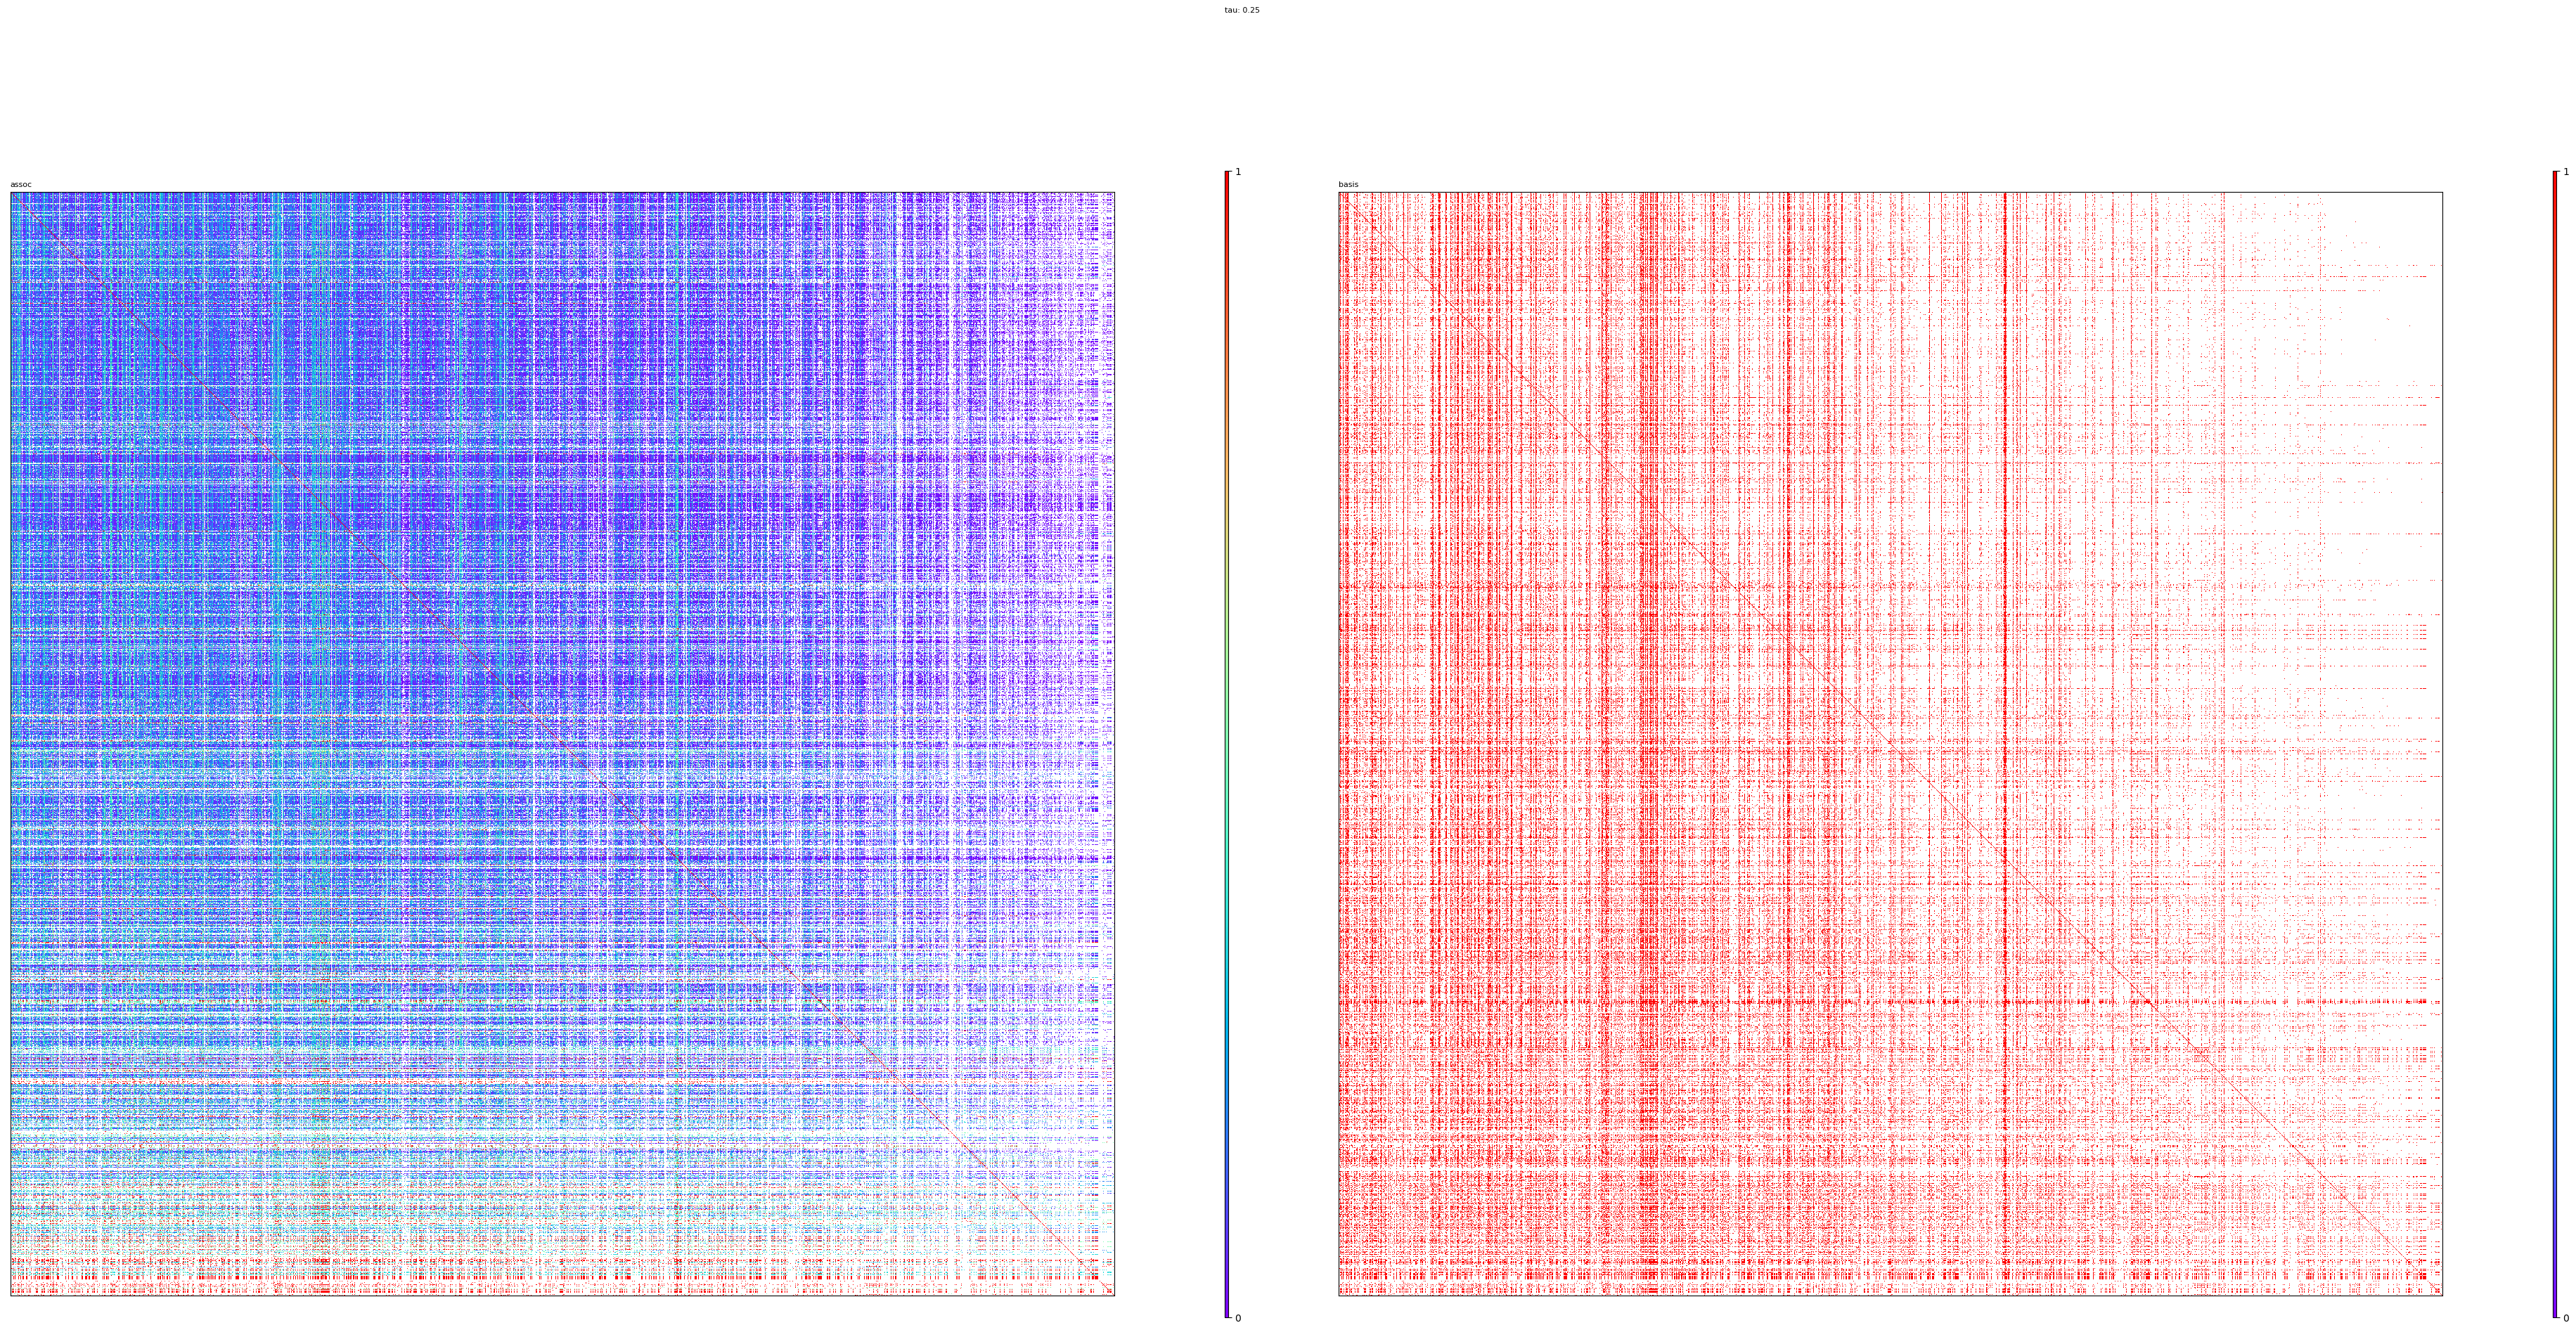

  0%|          | 0/1 [00:01<?, ?it/s]                       


KeyboardInterrupt: 

In [137]:
asso.fit(X_train=X_train, verbose=True, display=True)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0, dpi=1200)
for k in range(5):
    # plt.figure(k, dpi=1200)
    plt.plot(asso.scores[k], '.', markersize=1, label=[f"{k+1}_{i}" for i in range(len(asso.scores[k][0]))])
plt.legend()
plt.gca().set_aspect(0.1)

In [ ]:
n_candidates = 

In [ ]:
from random import sample

c_list = sample(list(np.arange(n_candidates)), 10)

print(c_list)

for candidate_id in c_list:
    show_matrix([(lil_matrix(patterns_U[candidate_id]), [0, 0], 'X')], discrete=True, cmap='grey')
    # show_matrix([(lil_matrix(patterns_U[candidate_id][-1, :]), [0, 0], 'X')], discrete=True, cmap='grey')

In [ ]:
patterns_U[candidate_id][0].sum()

In [ ]:
candidate_id = 1

for update_id in range(n_updates):
    c, r = patterns_U[candidate_id][update_id].sum(), patterns_V[candidate_id][update_id].sum()
    print(c, r, c*r)
    # X = matmul(patterns_U[candidate_id][update_id].T, patterns_V[candidate_id][update_id], sparse=True, boolean=True)
    # settings = [(X, [0, 0], 'X')]
    # show_matrix(settings)

In [ ]:
patterns_U[0][0][0, :10].toarray()

In [ ]:
patterns_U[0][1][0, :10].toarray()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0, dpi=1200)
for k in range(5):
    # plt.figure(k, dpi=1200)
    plt.plot(asso.scores[k], '.', markersize=1, label=[f"{k+1}_{i}" for i in range(len(asso.scores[k][0]))])
plt.legend()
plt.gca().set_aspect(0.1)